In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from PIL import Image

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [29]:
from sklearn.model_selection import train_test_split
dataset = ImageFolder("./cat_dog_dataset/training_dataset/")
train_data, test_data, train_label, test_label = train_test_split(dataset.imgs, dataset.targets, test_size=0.2, random_state=42)

# CatDogDataset
class CatDogDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.checkChannel(dataset) # some images are CMYK, Grayscale, check only RGB 
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = Image.open(self.dataset[idx][0]) # load the image using PIL.Image.open()
        label = self.dataset[idx][1]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            if (Image.open(dataset[index][0]).getbands() == ("R", "G", "B")): # Check Channels
                datasetRGB.append(dataset[index])
        return datasetRGB

In [30]:
img_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
]) # train transform

train_dataset = CatDogDataset(train_data, img_transform)
test_dataset = CatDogDataset(test_data, img_transform)
print("訓練資料總數:", len(train_dataset), ", ", "測試資料總數:", len(test_dataset))

訓練資料總數: 12919 ,  測試資料總數: 3234


In [31]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [6]:
from torchvision import models
# load pretrain model and modify...
model = models.resnet50(pretrained=True)

# If you want to do finetuning then set requires_grad = False
# Remove these two lines if you want to train entire model,
# and only want to load the pretrain weights.

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features # 修改 pretrained model 的參數
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [56]:
import torch.nn.functional as F
# 公式: (W - F + 2P) / S + 1
# W: 輸入圖像寬度
# F: Filter 寬度
# P: Padding
# S: Stride
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.layer1 = nn.Sequential(
            # Conv2d 參數： in-channel, out-channel, kernel size, Stride = 1, Padding = 0
            # input_size: 3*224*224
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # MaxPool2d 參數: kernel_size
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            # input_size: 3*112*112
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # MaxPool2d 參數: kernel_size
            nn.MaxPool2d(2))
                
        self.fc1 = nn.Linear(32*56*56, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self,x):        
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
model = MyCNN().to(device)

In [57]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []
# Train and test
def train(num_epoch, model):
    print("---start training---")
    for epoch in range(0, num_epoch):
        current_loss = 0.0
        current_corrects = 0
        model.train() # Set model to training mode
        print("---Epoch {} ---".format(epoch+1))
        for batch_idx, (data, targets) in enumerate(train_loader):
            # put the data to correct device
            data, targets = data.to(device), targets.to(device)

            # model forward
            output = model(data) 
            
            # calculate loss
            loss = criterion(output, targets) 
            
            # clear optimizer gradients
            optimizer.zero_grad()
            
            # backward to calculate gradients
            loss.backward()
            
            # update model parameters
            optimizer.step()
            
            _, preds = torch.max(output, 1)
            
            # loss.item() 返回當前 batch 的 loss value
            # data.size(0) 返回當前 batch 的 data size
            current_loss += loss.item() * data.size(0) 
            
            # 計算正確預測的資料總數
            current_corrects += (preds == targets).sum().item()
            
            # 計算當前 accuracy
            accuracy = int(current_corrects / len(train_loader.dataset) * 100)
            
            if batch_idx % 20 == 0:
                batch = batch_idx * len(data)
                
                # len(train_loader) 返回數據集被劃分為多少個批次進行訓練
                # len(train_loader.dataset) 返回數據集中包含多少資料數
                data_count = len(train_loader.dataset)
                percentage = (100. * batch_idx / len(train_loader))                
                print("Epoch {}/{} [{}/{}] ({:.0f}%) loss:{:.6f} accuracy:{:.3f}".format(epoch+1, num_epoch, batch, data_count, percentage, loss.item(), accuracy))
        
        # add loss to losses so as to display loss diagram
        train_losses.append(loss.item())
        
    # 保存整個模型
    torch.save(model, 'CatDog.pth')

In [58]:
num_epoch = 20
if __name__ == "__main__":
    train(num_epoch, model) # train

---start training---
---Epoch 1 ---
Epoch 1/20 [0/12919] (0%) loss:0.711311 accuracy:0.000
Epoch 1/20 [1280/12919] (10%) loss:133.156860 accuracy:5.000
Epoch 1/20 [2560/12919] (20%) loss:6.206919 accuracy:11.000
Epoch 1/20 [3840/12919] (30%) loss:1.599544 accuracy:17.000
Epoch 1/20 [5120/12919] (40%) loss:0.918664 accuracy:23.000
Epoch 1/20 [6400/12919] (50%) loss:0.990473 accuracy:29.000
Epoch 1/20 [7680/12919] (59%) loss:0.791634 accuracy:35.000
Epoch 1/20 [8960/12919] (69%) loss:0.524451 accuracy:42.000
Epoch 1/20 [10240/12919] (79%) loss:0.568877 accuracy:48.000
Epoch 1/20 [11520/12919] (89%) loss:0.632132 accuracy:55.000
Epoch 1/20 [12800/12919] (99%) loss:0.600345 accuracy:61.000
---Epoch 2 ---
Epoch 2/20 [0/12919] (0%) loss:0.550897 accuracy:0.000
Epoch 2/20 [1280/12919] (10%) loss:0.595186 accuracy:7.000
Epoch 2/20 [2560/12919] (20%) loss:0.579407 accuracy:14.000
Epoch 2/20 [3840/12919] (30%) loss:0.588026 accuracy:20.000
Epoch 2/20 [5120/12919] (40%) loss:0.711746 accuracy:27.

[0.5081068277359009, 0.7614941000938416, 0.6036407351493835, 0.5103622078895569, 0.6144400238990784, 0.8823454976081848, 0.5253902077674866, 0.6548153758049011, 0.4136984050273895, 0.5193547010421753, 0.3911575973033905, 0.5161793231964111, 0.5577844381332397, 0.6635052561759949, 0.4703730642795563, 0.38384753465652466, 0.486131876707077, 0.26999884843826294, 0.19663462042808533, 0.3818717300891876]


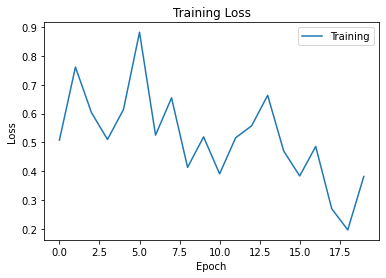

In [59]:
import matplotlib.pyplot as plt
x = list(range(num_epoch))
print(train_losses)
plt.plot(x, train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training'])
plt.show()

In [60]:
# Dropout 層和 Batch Normalization 層的行為發生變化：
# 在訓練模式下，Dropout 層會隨機丟棄一部分神經元，而 Batch Normalization 層會根據當前 batch 中的統計信息對數據進行歸一化，以增強模型的泛化能力。
# 在評估模式下，為了保證模型的穩定性，這些層的行為會有所不同，具體而言，Dropout 層不再丟棄神經元，而是將輸入數據按照 dropout 概率進行縮放；
# Batch Normalization 層使用整個數據集的統計信息對數據進行歸一化，以便得到更準確的歸一化結果。
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # 關掉梯度計算
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            output = model(imgs)
            _, pred = torch.max(output, 1)
            correct += (pred == labels).sum().item()
            test_loss = criterion(output, labels)
            
    test_loss /= len(test_loader.dataset)
    print("Accuracy: {}/{}  {:.0f}%".format(correct, len(test_loader.dataset), (correct / len(test_loader.dataset) * 100)))

In [61]:
if __name__ == "__main__":
    test()

Accuracy: 2313/3234  72%


In [62]:
import matplotlib.image as imgs
%matplotlib inline

# create a function to predict random cats and dog images
def Prediction(filepath):
    img_array = Image.open(filepath).convert("RGB")
    data_transforms=transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(), 
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    img = data_transforms(img_array).unsqueeze(dim=0) # Returns a new tensor with a dimension of size one inserted at the specified position.
    load = DataLoader(img)
    
    image = imgs.imread(filepath)
    plt.imshow(image)
    plt.show()
    
    for x in load:
        x = x.to(device)
        pred = model(x)
        _, preds = torch.max(pred, 1)
        print(f"class : {preds}")
        if preds[0] == 1: print(f"predicted ----> Dog")
        else: print(f"predicted ----> Cat")

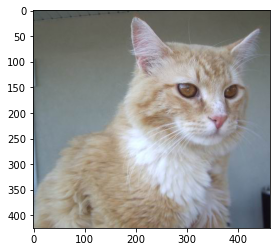

class : tensor([0], device='cuda:0')
predicted ----> Cat


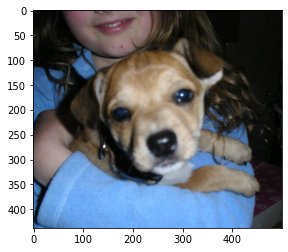

class : tensor([0], device='cuda:0')
predicted ----> Cat


In [63]:
if __name__ == "__main__":
    Prediction("./cat_dog_dataset/inference_dataset/Cat/8043.jpg") # cat image
    Prediction("./cat_dog_dataset/inference_dataset/Dog/12053.jpg") # dog image